## Описание проекта

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## Описание таблиц

- collisions — общая информация о ДТП
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
- parties — информация об участниках ДТП
Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
- vehicles — информация о пострадавших машинах
Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Импорт модулей

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import sweetviz as sv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import shap


## Константы

In [2]:
SEED = 123
SCORE = 'accuracy'

## Подключение к базе SQL

Создадим подключение к базе данных.

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)


## Первичное исследование таблиц

Проверим все ли таблицы имеют набор данных, для этого создадим SQL-запросы.

In [4]:
for table in ['collisions', 'parties', 'vehicles']:
    query = f'''
    SELECT *
    FROM {table}
    LIMIT 5;
    '''
    print(f'Таблица {table}')
    display(pd.read_sql_query(query, con=engine))


Таблица collisions


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Таблица parties


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Таблица vehicles


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Можно видеть, что таблицы соответствуют условию задачи и имеют общий ключ для связи таблиц.

##  Статистический анализ факторов ДТП

Выясним в какие месяцы происходит наибольшее количество аварий за весь период наблюдений (таблица collisions). Выберем все типы ущерба от столкновений кроме scratch (по условию задачи такой ущерб не важен).

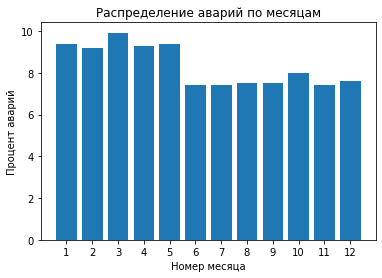

In [5]:
query_collision_month = '''
SELECT EXTRACT(month FROM collision_date)::int AS month,
       COUNT(*) AS collisions
FROM collisions
WHERE collision_damage <> 'scratch'
GROUP BY EXTRACT(month FROM collision_date)::int;
'''

collision_month_df = pd.read_sql_query(query_collision_month, con=engine)
collision_month_df['collision_percent'] = 100 * collision_month_df['collisions'] \
                                              / collision_month_df['collisions'].sum()

plt.bar(collision_month_df['month'],
        collision_month_df['collision_percent'])
plt.xticks(collision_month_df['month'])
plt.ylabel('Процент аварий')
plt.xlabel('Номер месяца')
plt.title('Распределение аварий по месяцам')
plt.show()


Из графика можно видеть, что наибольшее количество аварий происходит в начале года - с января по май. Это может быть связано с ухудшенными условиями вождения в зимние и весенние месяцы.

### Аналитические задачи

Список задач:
1. Найдите регионы с самым большим числом ДТП (таблица collisions).
2. Проверьте зависимость состояния участника (физическое или с учетом принятых лекарств) и погоды (связать parties и collisions).
3. Проверьте наличие корреляции между временем года и состоянием алкогольного опьянения участника ДТП (связать parties и collisions).
4. Проверьте зависимость между типом кузова автомобиля и типом аварии (связать vehicles и collisions).
5. Найти зависимость между типом аварии и серьезностью ДТП (таблица collisions).
6. Выясните в какое время суток происходит больше всего аварий (таблица collisions).
7. Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties).
8. Найдите самые частые причины ДТП (таблица parties).

Порядок решения задач:
1. Проверить зависимость между временем года и алкогольным опьянением:
    - создайте SQL запрос и свяжите таблицы parties и collisions
    - выделите месяц из колонки collision date
    - постройте столбчатую диаграмму, по оси 0х отложите месяц, а по оси 0у - уровень опьянения
    - сделайте вывод
2. Проверить зависимость между типом аварии и типом кузова автомобиля:
    - создайте SQL запрос и свяжите vehicles и collisions
    - постройте столбчатую диаграмму (тип кузова на оси абсцисс, тип аварии на оси ординат)
    - сделайте вывод

## Модель для оценки водительского риска

- Соединим таблицы parties и collisions по полю case_id так, чтобы все значения parties вошли в итоговую таблицу. К полученной таблице присоединим vehicles по полям case_id и party_number.
- Выберем тип виновника — только машина (car).
- Возьмем случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмем данные только за 2012 год.

In [6]:
query_df = '''
SELECT *,
       EXTRACT(month FROM collisions.collision_date)::int AS collision_month,
       EXTRACT(isodow FROM collisions.collision_date)::int AS collision_dow
FROM parties
JOIN collisions
ON parties.case_id = collisions.case_id
JOIN vehicles
ON parties.case_id = vehicles.case_id AND parties.party_number = vehicles.party_number
WHERE parties.party_type = 'car' AND
      collisions.collision_damage <> 'scratch' AND
      EXTRACT(year FROM collisions.collision_date)::int = 2012;
'''

df = pd.read_sql_query(query_df, con=engine)
display(df.head())
print(f'Размер исследуемого набора данных: {df.shape}')


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,...,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,collision_month,collision_dow
0,2413269,5458439,2,car,0,51.0,had not been drinking,None,0.0,5458439,...,2012-01-10,15:10:00,1330128,5458439,2,sedan,manual,8.0,1,2
1,2395824,5449062,2,car,0,54.0,had not been drinking,None,0.0,5449062,...,2012-01-15,02:00:00,1320506,5449062,2,sedan,manual,10.0,1,7
2,2407865,5455644,3,car,1,22.0,had not been drinking,None,0.0,5455644,...,2012-01-02,15:32:00,1327255,5455644,3,sedan,manual,3.0,1,1
3,2407928,5455680,3,car,0,59.0,had not been drinking,None,0.0,5455680,...,2012-01-01,22:06:00,1327290,5455680,3,sedan,manual,NaN,1,7
4,2407938,5455686,1,car,1,30.0,had not been drinking,None,0.0,5455686,...,2012-01-01,03:00:00,1327306,5455686,1,sedan,manual,3.0,1,7


Размер исследуемого набора данных: (56248, 37)


Проверим наличие пропущенных значений и дубликатов.

In [7]:
print(f'Количество дубликатов: {df.duplicated().sum()}')
print('Количество пропусков:')
df.isna().sum()


Количество дубликатов: 0
Количество пропусков:


id                                 0
case_id                            0
party_number                       0
party_type                         0
at_fault                           0
insurance_premium                547
party_sobriety                   872
party_drug_physical            53391
cellphone_in_use                4471
case_id                            0
county_city_location               0
county_location                    0
distance                           0
direction                      13018
intersection                     175
weather_1                        168
location_type                  30316
collision_damage                   0
party_count                        0
primary_collision_factor         111
pcf_violation_category           766
type_of_collision                308
motor_vehicle_involved_with      162
road_surface                     348
road_condition_1                 249
lighting                         154
control_device                   215
c

Можно видеть, что в столбцах party_drug_physical, direction, location_type отсутствует большое количество данных, по этой причине эти столбцы можно не включать в данные для моделирования. В остальных столбцах требуется произвести замену пропущенных значений.

Проведем первичный отбор факторов, необходимых для модели.

In [8]:
features = ['at_fault', # целевая переменная
            # Погодные и дорожные условия. Таблица collisions
            'collision_month', # погодные условия влияют на вероятность аварии
            'collision_dow', # день недели влияет на уровень трафика
            'weather_1', # влияет на условия вождения и вероятность аварии
            'road_surface', # дополняет погодные условия
            'lighting', # влияет на условия вождения и вероятность аварии
            'intersection', # наличие перекрестка на маршруте может влиять на вероятность аварии
            'road_condition_1', # наличие опасного участка дороги на маршруте влияет на вероятность аварии
            # Состояние водителя. Таблица parties
            'party_sobriety', # напрямую влияет на вероятность аварии
            'cellphone_in_use', # отсутствие громкой связи может мешать вождению
            # Особенности автомобиля. Таблица vehicles
            'vehicle_age', # может приводить к изменению управляемости автомобиля
            'vehicle_type', # влияет на управляемость автомобиля и может менять вероятность аварии
            'vehicle_transmission' # также влияет на управляемость авто
            ]

df = df[features].rename(columns={'weather_1': 'weather',
                                  'road_condition_1': 'road_condition',
                                  'party_sobriety': 'sobriety',
                                  'cellphone_in_use': 'cellphone',
                                  'at_fault': 'fault'})
df.head()


,fault,collision_month,collision_dow,weather,road_surface,lighting,intersection,road_condition,sobriety,cellphone,vehicle_age,vehicle_type,vehicle_transmission
0,0,1,2,clear,dry,daylight,0.0,normal,had not been drinking,0.0,8.0,sedan,manual
1,0,1,7,clear,dry,dark with street lights,0.0,normal,had not been drinking,0.0,10.0,sedan,manual
2,1,1,1,cloudy,dry,daylight,0.0,normal,had not been drinking,0.0,3.0,sedan,manual
3,0,1,7,clear,dry,dark with street lights,1.0,normal,had not been drinking,0.0,NaN,sedan,manual
4,1,1,7,fog,dry,dark with no street lights,0.0,normal,had not been drinking,0.0,3.0,sedan,manual


Заменим пропущенные значения в столбцах со строковыми данными на 'unknown', а с числовыми на медианное значение.

In [9]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna('unknown')
    else:
        df[column] = df[column].fillna(df[column].median()).astype('int32')


Разделим признаки на категориальные, числовые и целевой.

In [10]:
target_col = 'fault'
num_cols = ['collision_month', 'collision_dow', 'vehicle_age']
cat_cols = [col for col in df.columns if col not in [target_col] + num_cols]

df[num_cols].describe()


,collision_month,collision_dow,vehicle_age
count,56248.000000,56248.000000,56248.000000
mean,3.233786,4.164255,4.830678
std,1.808481,1.969307,3.188786
min,1.000000,1.000000,0.000000
25%,2.000000,2.000000,3.000000
50%,3.000000,4.000000,4.000000
75%,4.000000,6.000000,7.000000
max,12.000000,7.000000,161.000000


Колонка vehicle_age имеет выбросы, заменим их величиной 95 процентиля после разделения выборки на части.

Проверим уникальные значения строковых данных.

In [12]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f'Столбец {column}:')
        print(df[column].unique())
        print()


Столбец weather:
['clear' 'cloudy' 'fog' 'raining' 'unknown' 'snowing' 'other' 'wind']

Столбец road_surface:
['dry' 'wet' 'unknown' 'slippery' 'snowy']

Столбец lighting:
['daylight' 'dark with street lights' 'dark with no street lights'
 'dusk or dawn' 'unknown' 'dark with street lights not functioning']

Столбец road_condition:
['normal' 'unknown' 'loose material' 'obstruction' 'construction' 'holes'
 'other' 'reduced width' 'flooded']

Столбец sobriety:
['had not been drinking' 'had been drinking, under influence'
 'had been drinking, not under influence' 'impairment unknown' 'unknown'
 'not applicable' 'had been drinking, impairment unknown']

Столбец vehicle_type:
['sedan' 'coupe' 'other']

Столбец vehicle_transmission:
['manual' 'auto' 'unknown']



Данные имеют корректные значения.

Проверим наличие дубликатов после отбора признаков.

In [13]:
print(f'Количество пропусков: {df.isna().sum().sum()}')
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество пропусков: 0
Количество дубликатов: 27276


После удаления части признаков появились дубликаты, удалим их.

In [14]:
df = df.drop_duplicates()
print(f'Размер набора данных после отбора признаков: {df.shape}')


Размер набора данных после отбора признаков: (28972, 13)


Проведем исследовательский анализ данных с помощью пакета sweetviz.

                                             |          | [  0%]   00:00 -> (? left)


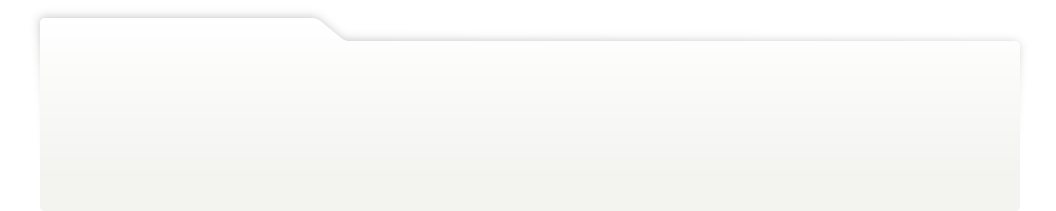
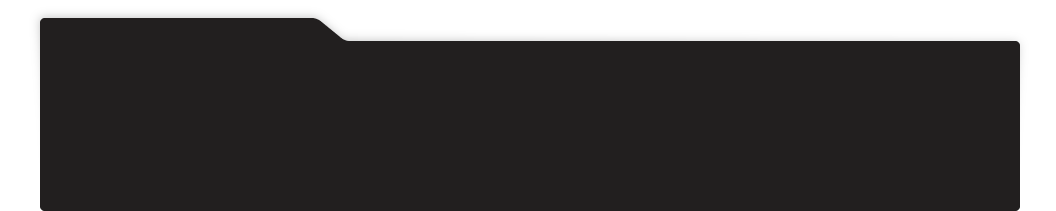
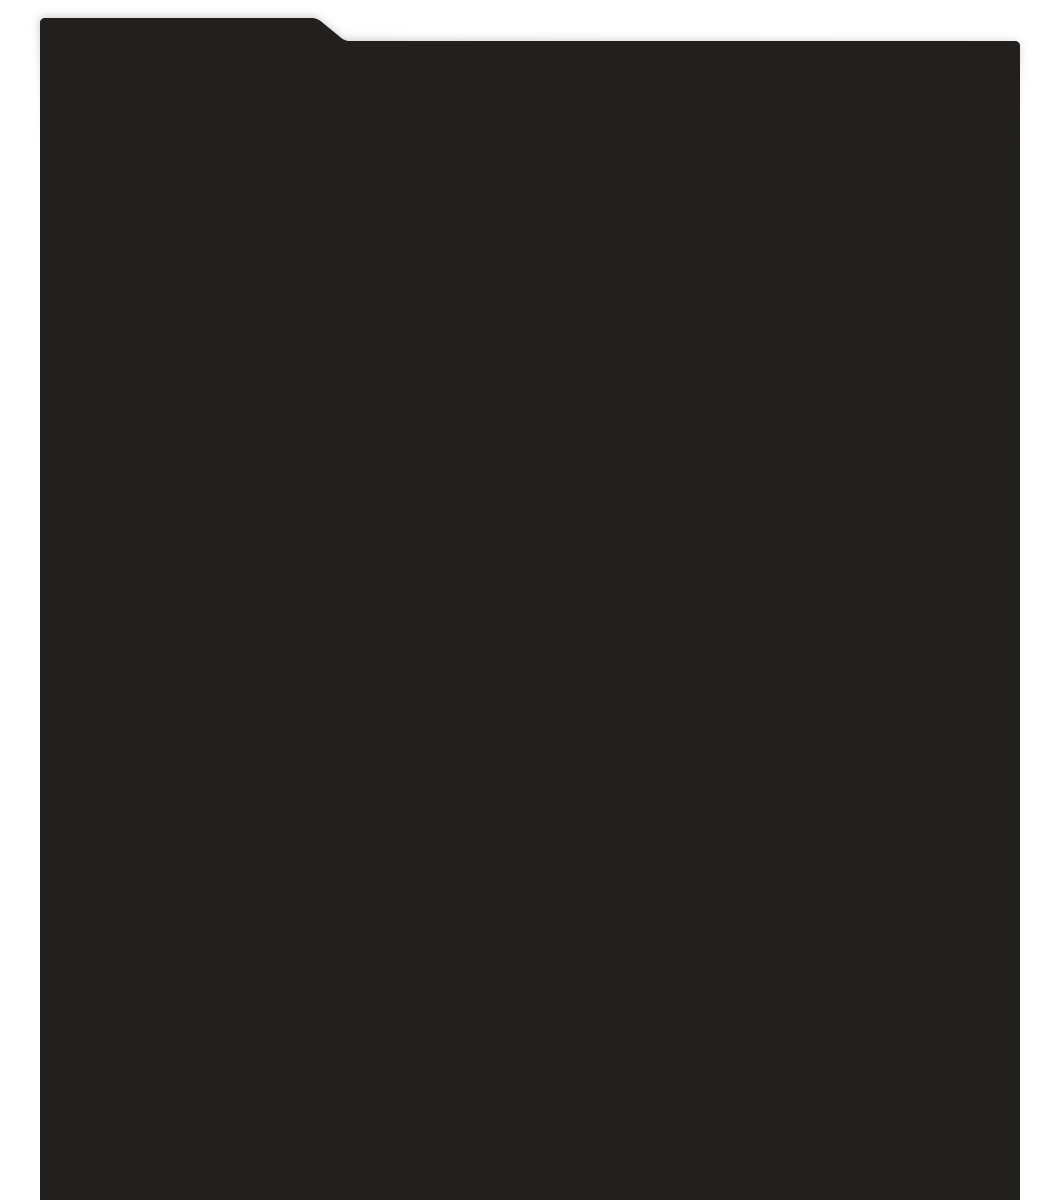
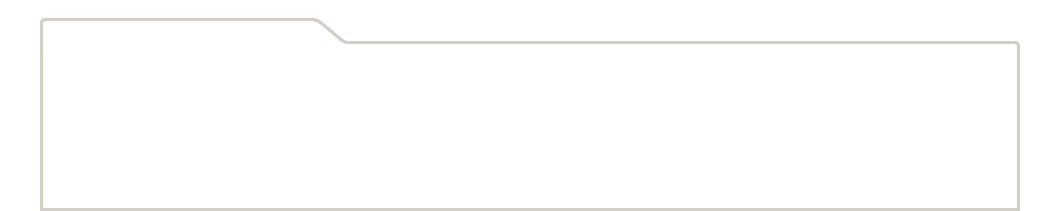
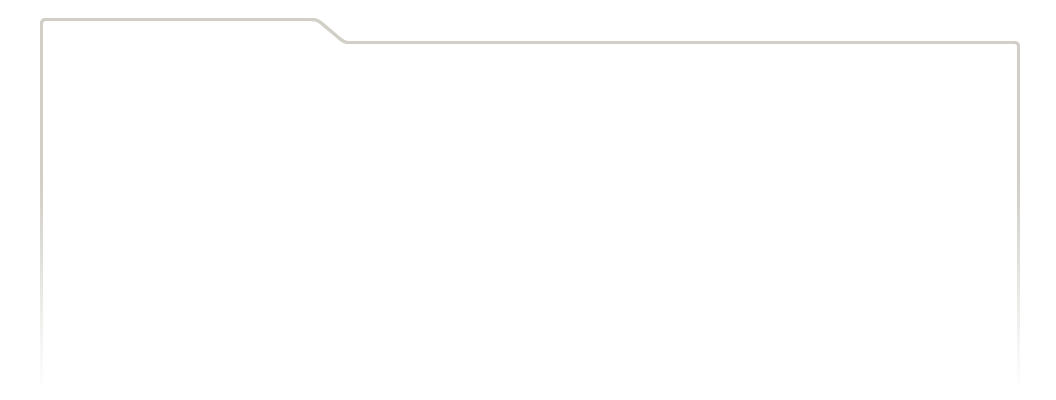
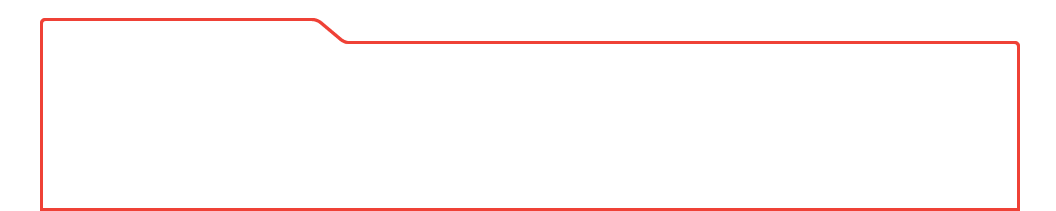
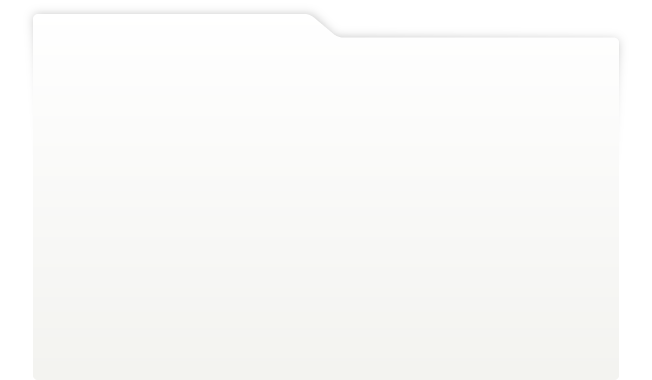
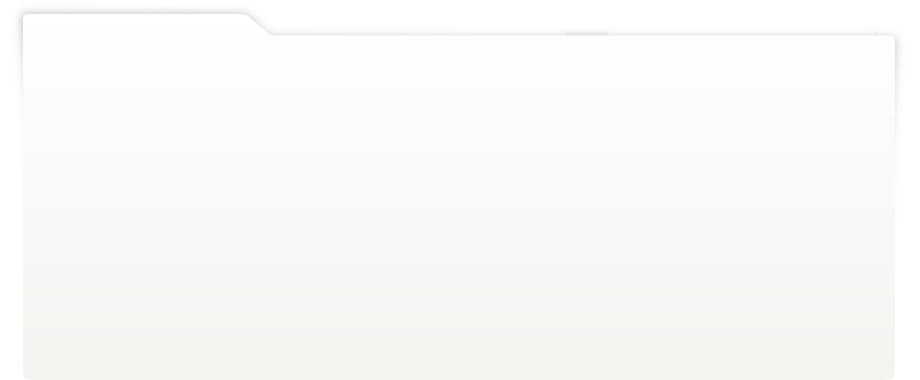
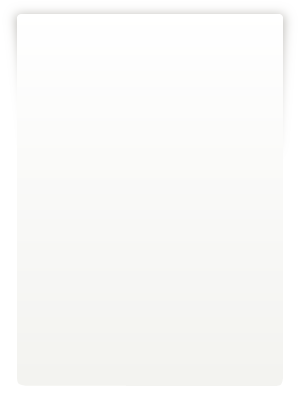
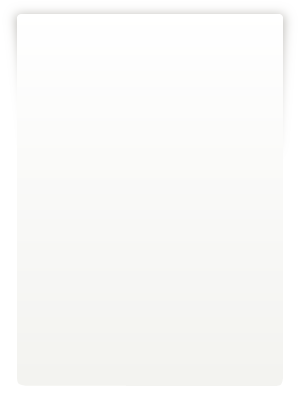
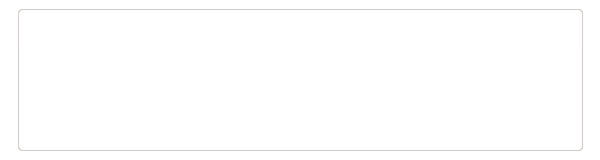
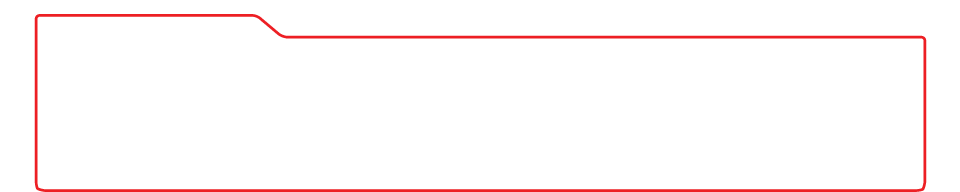
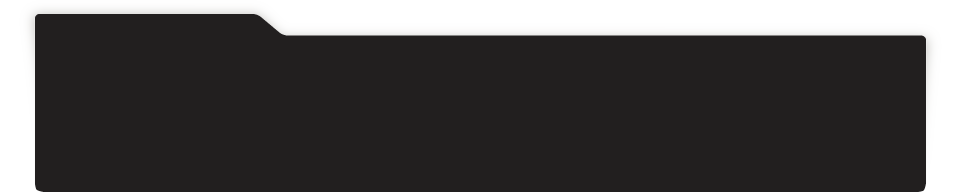
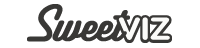
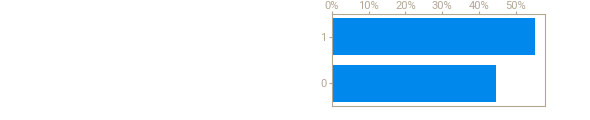
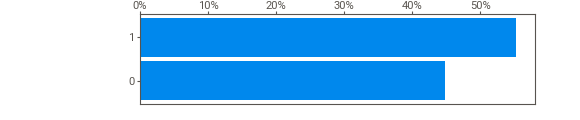
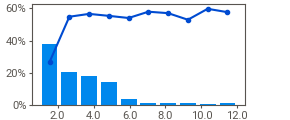
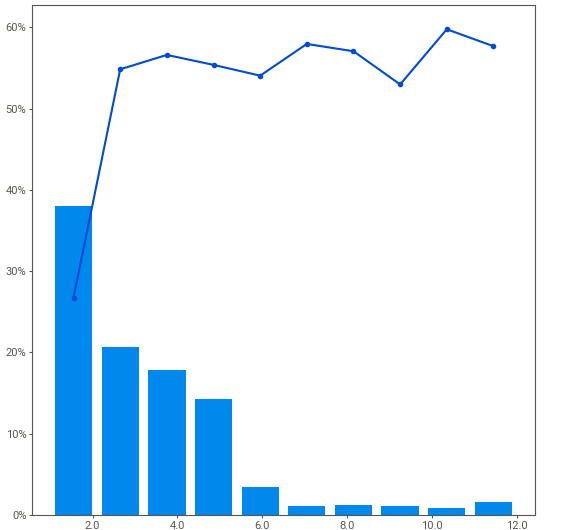
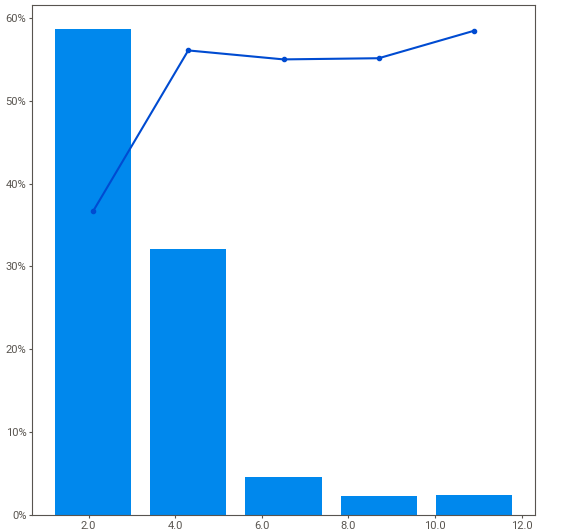
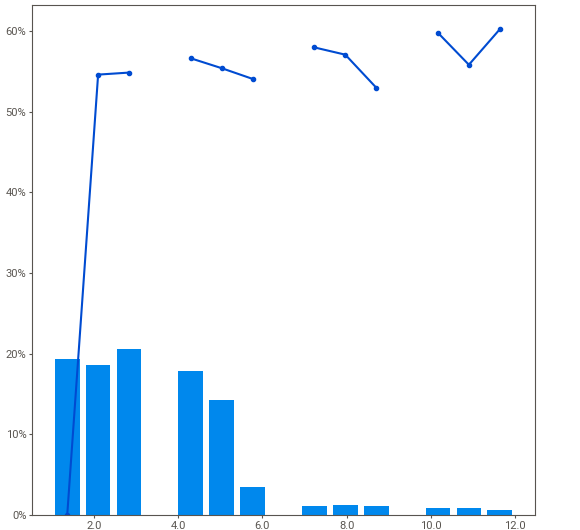
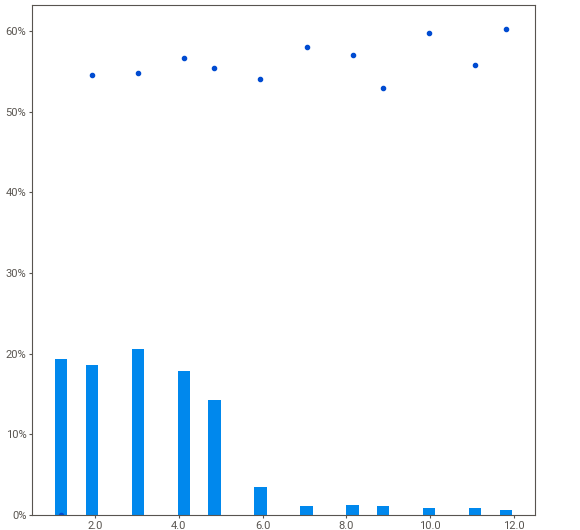
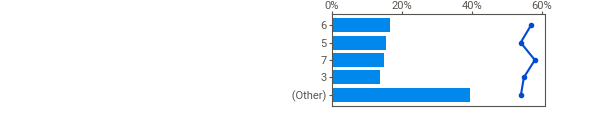
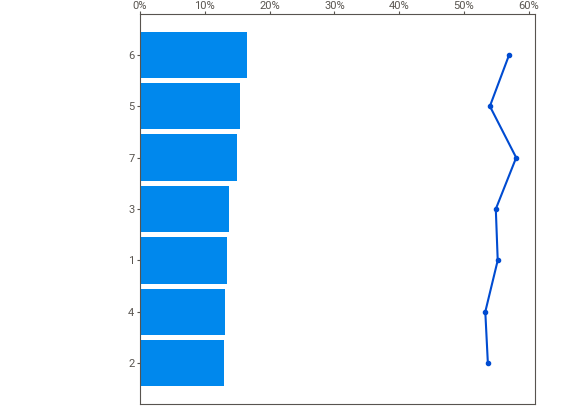
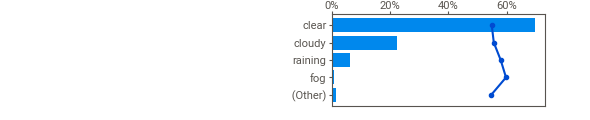
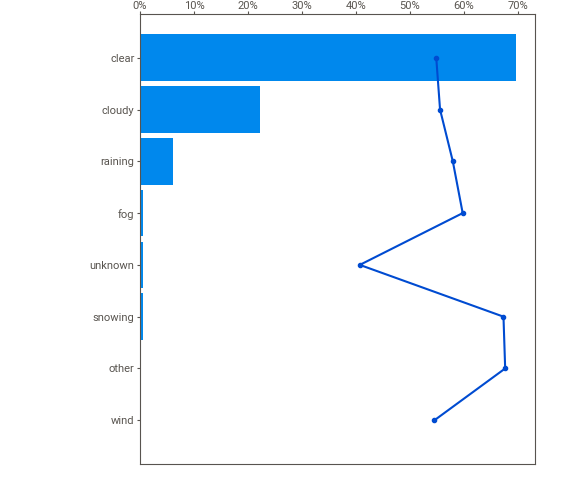
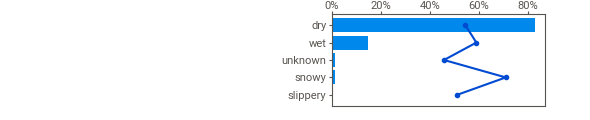
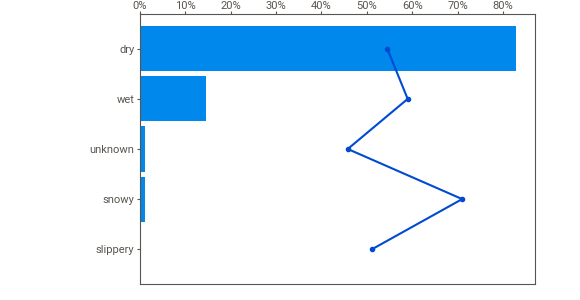
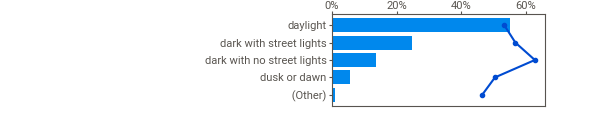
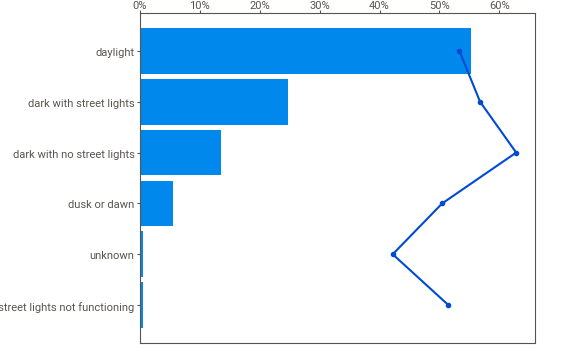
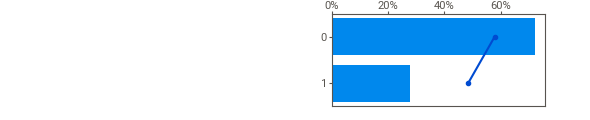
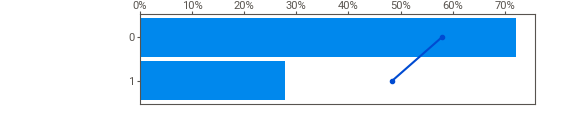
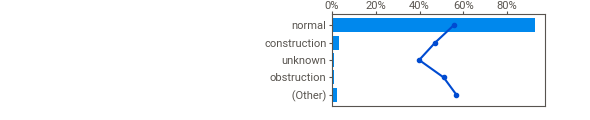
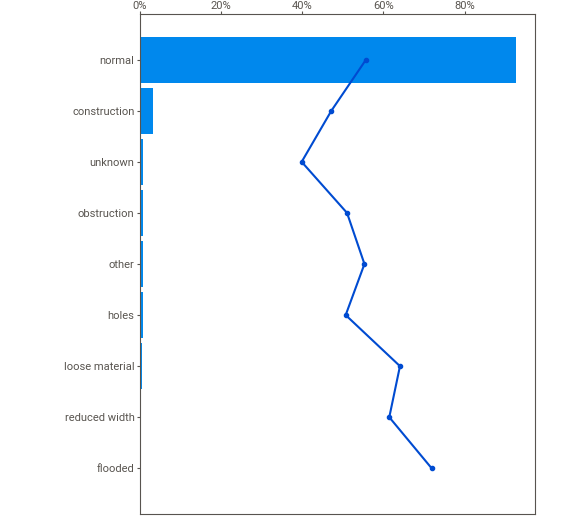
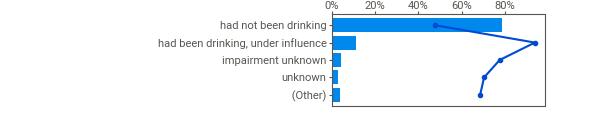
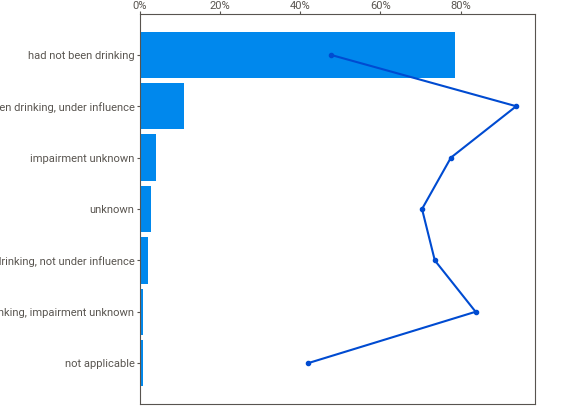
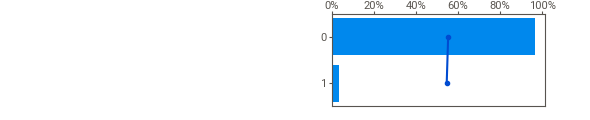
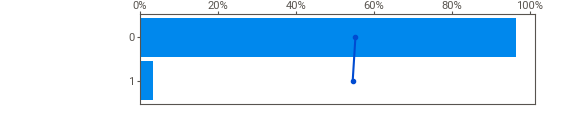
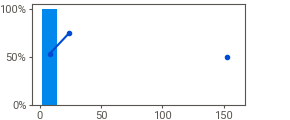
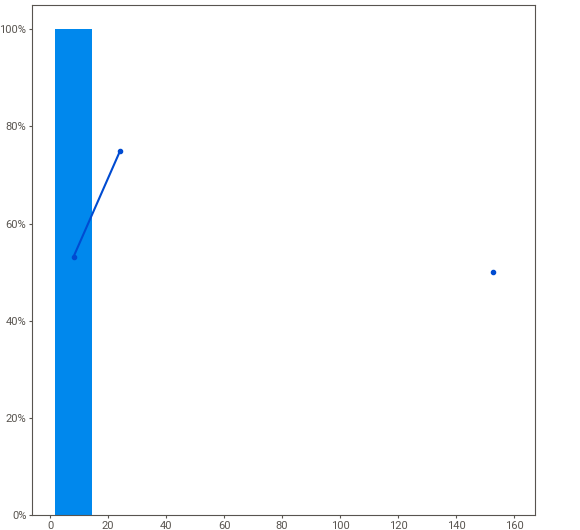
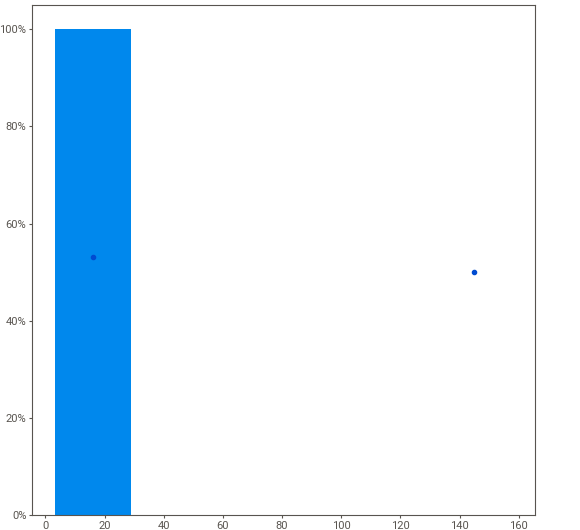
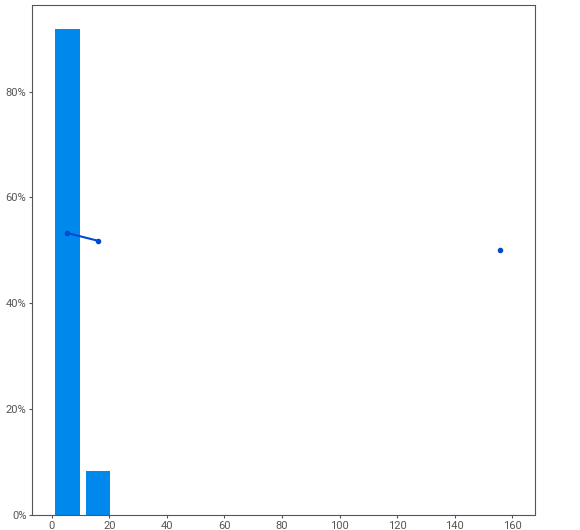
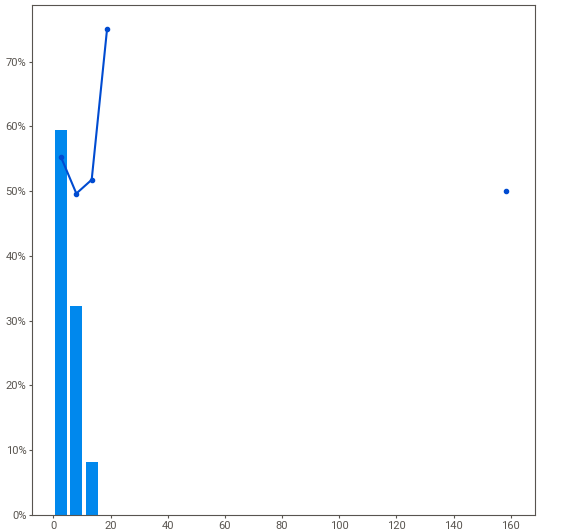
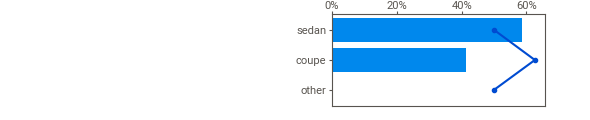
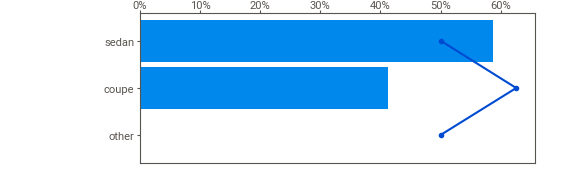
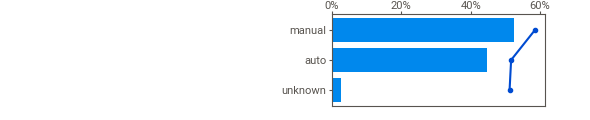
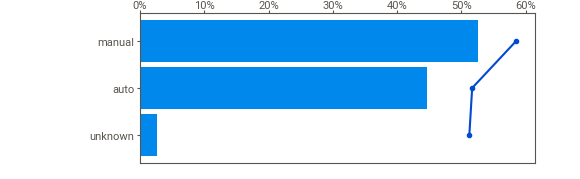
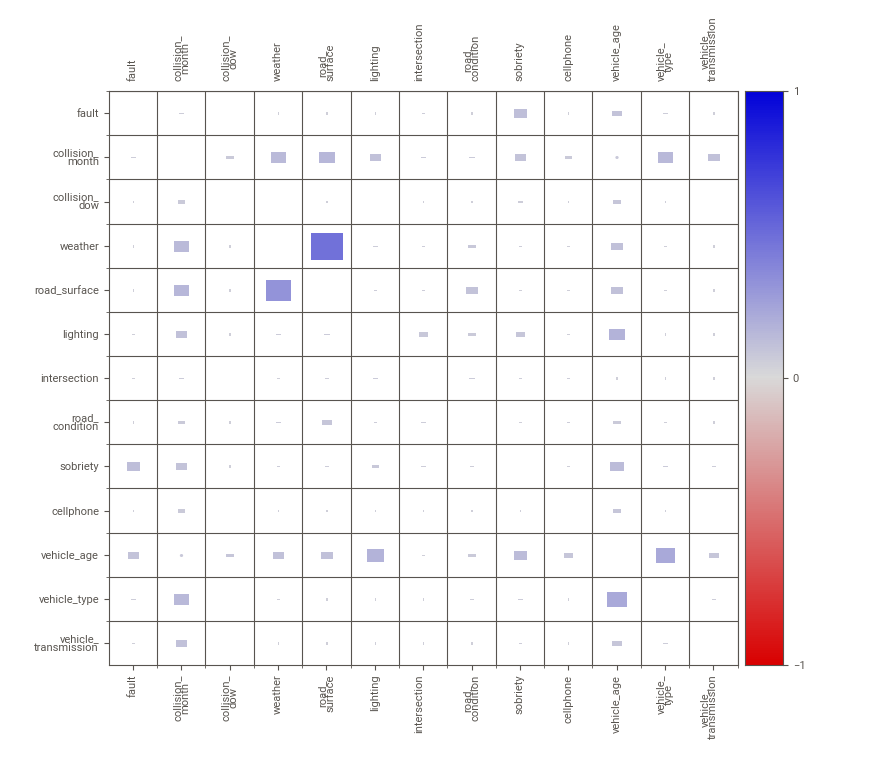
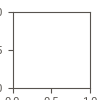

In [15]:
report = sv.analyze(source=(df, 'Collisions'), target_feat='fault')
report.show_notebook()

Исследовательский анализ данных показал, что целевой признак сильнее всего коррелирует с состоянием алкогольного опьянения и возрастом автомобиля. По-видимому, оба эти фактора оказывают наибольшее влияние на управляемость транспортным средством. Кроме этого вероятность вины в ДТП повышается в выходные дни, в снежную погоду, на улице без освещения, на дороге без перекрестка, при отсутствии телефона в машине, а также при вождении автомобиля купе с ручной коробкой передач.

### Кодирование признаков

Разделим выборку на тренировочную (для подбора гиперпаратеров), валидационную (для сравнения моделей) и тестовую (для тестирования лучшей модели) части.

In [17]:
X = df.drop(columns=target_col)
y = df[target_col]

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y,
                                                                test_size=0.2,
                                                                stratify=y,
                                                                random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
                                                      test_size=0.25,
                                                      stratify=y_train_valid,
                                                      random_state=SEED)


Удалим выбросы в тренировочной части выборки, остальные оставим без изменений.

In [18]:
vehicle_age_threshold = X_train['vehicle_age'].quantile(0.95)
X_train['vehicle_age'] = X_train['vehicle_age'].apply(lambda x: x if x <= vehicle_age_threshold
                                                                  else vehicle_age_threshold)


Проведем кодирование признаков со строковыми значениями.

In [19]:
features_coder = {
    'weather':              {'unknown': 0,
                             'clear': 1,
                             'cloudy': 2,
                             'raining': 3,
                             'fog': 4,
                             'snowing': 5,
                             'wind': 6,
                             'other': 7},
    'road_surface':         {'unknown': 0,
                             'dry': 1,
                             'wet': 2,
                             'slippery': 3,
                             'snowy': 4},
    'lighting':             {'unknown': 0,
                             'daylight': 1,
                             'dusk or dawn': 2,
                             'dark with no street lights': 3,
                             'dark with street lights': 4,
                             'dark with street lights not functioning': 5},
    'road_condition':       {'unknown': 0,
                             'normal': 1,
                             'construction': 2,
                             'holes': 3,
                             'obstruction': 4,
                             'loose material': 5,
                             'reduced width': 6,
                             'flooded': 7,
                             'other': 8},
    'sobriety':             {'unknown': 0,
                             'had not been drinking': 1,
                             'had been drinking, under influence': 2,
                             'had been drinking, not under influence': 3,
                             'impairment unknown': 4,
                             'not applicable': 5,
                             'had been drinking, impairment unknown': 6},
    'vehicle_type':         {'other': 0,
                             'sedan': 1,
                             'coupe': 2},
    'vehicle_transmission': {'unknown': 0,
                             'auto': 1,
                             'manual': 2}
}

cat_cols_object = [col for col in cat_cols if df[col].dtype == 'object']
features_coder_list = [[i[0] for i in sorted(features_coder[col].items(), key=lambda x: x[1])]
                       for col in cat_cols_object]

ordinal = OrdinalEncoder(categories=features_coder_list)

X_train[cat_cols_object] = ordinal.fit_transform(X_train[cat_cols_object]).astype('int32')
X_valid[cat_cols_object] = ordinal.transform(X_valid[cat_cols_object]).astype('int32')
X_test[cat_cols_object] = ordinal.transform(X_test[cat_cols_object]).astype('int32')

X_train.head()


,collision_month,collision_dow,weather,road_surface,lighting,intersection,road_condition,sobriety,cellphone,vehicle_age,vehicle_type,vehicle_transmission
1056,3,7,2,1,1,1,1,1,0,7.0,1,2
11777,3,6,1,1,1,1,1,1,0,11.0,2,1
10966,1,6,1,1,4,0,1,1,0,3.0,1,1
3839,3,7,1,1,4,1,1,1,0,3.0,2,2
17860,4,5,1,1,1,1,1,1,0,11.0,1,1


Масштабируем числовые признаки.

In [20]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

display(X_train.head())

print(f'Размер X_train: {X_train.shape}')
print(f'Размер X_valid: {X_valid.shape}')
print(f'Размер X_test: {X_test.shape}')


,collision_month,collision_dow,weather,road_surface,lighting,intersection,road_condition,sobriety,cellphone,vehicle_age,vehicle_type,vehicle_transmission
1056,-0.177620,1.426181,2,1,1,1,1,1,0,0.578639,1,2
11777,-0.177620,0.923487,1,1,1,1,1,1,0,1.887282,2,1
10966,-1.137329,0.923487,1,1,4,0,1,1,0,-0.730004,1,1
3839,-0.177620,1.426181,1,1,4,1,1,1,0,-0.730004,2,2
17860,0.302235,0.420792,1,1,1,1,1,1,0,1.887282,1,1


Размер X_train: (17382, 12)
Размер X_valid: (5795, 12)
Размер X_test: (5795, 12)


Создадим дополнительный набор данных с OHE кодированием переменных.

In [21]:
X_train_ohe = X_train.copy()
X_valid_ohe = X_valid.copy()
X_test_ohe = X_test.copy()

ohe = OneHotEncoder(drop='first')
X_train_ohe_values = ohe.fit_transform(X_train_ohe[cat_cols]).toarray().astype('int32')
X_valid_ohe_values = ohe.transform(X_valid_ohe[cat_cols]).toarray().astype('int32')
X_test_ohe_values = ohe.transform(X_test_ohe[cat_cols]).toarray().astype('int32')

X_train_ohe[list(ohe.get_feature_names_out())] = X_train_ohe_values
X_valid_ohe[list(ohe.get_feature_names_out())] = X_valid_ohe_values
X_test_ohe[list(ohe.get_feature_names_out())] = X_test_ohe_values

X_train_ohe = X_train_ohe.drop(columns=cat_cols)
X_valid_ohe = X_valid_ohe.drop(columns=cat_cols)
X_test_ohe = X_test_ohe.drop(columns=cat_cols)

display(X_train_ohe.head())

print(f'Размер X_train_ohe: {X_train_ohe.shape}')
print(f'Размер X_valid_ohe: {X_valid_ohe.shape}')
print(f'Размер X_test_ohe: {X_test_ohe.shape}')


,collision_month,collision_dow,vehicle_age,weather_1,weather_2,weather_3,weather_4,weather_5,weather_6,weather_7,...,sobriety_2,sobriety_3,sobriety_4,sobriety_5,sobriety_6,cellphone_1,vehicle_type_1,vehicle_type_2,vehicle_transmission_1,vehicle_transmission_2
1056,-0.177620,1.426181,0.578639,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
11777,-0.177620,0.923487,1.887282,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
10966,-1.137329,0.923487,-0.730004,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3839,-0.177620,1.426181,-0.730004,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
17860,0.302235,0.420792,1.887282,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Размер X_train_ohe: (17382, 39)
Размер X_valid_ohe: (5795, 39)
Размер X_test_ohe: (5795, 39)


## Поиск лучшей модели

Для подбора гиперпараметров и оценки моделей будем использовать метрику accuracy. Будем использовать именно эту метрику, т.к. в наборе данных наблюдается сбалансированность меток целевого признака, а также из-за того оба класса предсказаний (виновен в ДТП или нет) одинаково важны для конечной модели. Для тренировки и оценки моделей будем использовать наборы данных после OHE для того чтобы было возможно оценить важность признаков.

### Логистическая регрессия

In [22]:
fit_lr = False
if fit_lr:
    params_lr = {'penalty': ['l2', 'l1'],
                 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                 'fit_intercept': [True, False]}

    grid_lr = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000,
                                                              solver='saga'),
                                 param_distributions=params_lr,
                                 scoring=SCORE,
                                 cv=5,
                                 n_iter=30,
                                 random_state=SEED,
                                 n_jobs=-1,
                                 verbose=1)

    grid_lr.fit(X_train_ohe, y_train)
    print(grid_lr.best_params_)


Гиперпараметры: {'penalty': 'l1', 'fit_intercept': True, 'C': 0.1}

In [23]:
lr = LogisticRegression(max_iter=10000, solver='saga',
                        penalty='l1', fit_intercept=True, C=0.1)

lr.fit(X_train_ohe, y_train)
predict_lr = lr.predict(X_valid_ohe)
accuracy_lr = accuracy_score(y_valid, predict_lr)

print(f'Логистическая регрессия.\n'
      f'Валидационная выборка.\n'
      f'Accuracy_score: {accuracy_lr:.3f}')


Логистическая регрессия.
Валидационная выборка.
Accuracy_score: 0.612


### Случайный лес

In [24]:
fit_rf = False
if fit_rf:
    params_rf = {'n_estimators': [100, 200, 300, 400, 500],
                 'max_depth': [3, 5, 7, 9, 11, 13, 15, 17],
                 'min_samples_leaf': [3, 5, 6, 7, 8, 9, 10, 11],
                 'min_samples_split': [2, 3, 4, 5, 6, 7, 8]}

    grid_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                                 param_distributions=params_rf,
                                 scoring=SCORE,
                                 cv=5,
                                 n_iter=300,
                                 random_state=SEED,
                                 n_jobs=-1,
                                 verbose=1)

    grid_rf.fit(X_train_ohe, y_train)
    print(grid_rf.best_params_)


Гиперпараметры: {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_depth': 7}

In [25]:
rf = RandomForestClassifier(random_state=SEED,
                            n_estimators=100, min_samples_split=7,
                            min_samples_leaf=6, max_depth=7)

rf.fit(X_train_ohe, y_train)
predict_rf = rf.predict(X_valid_ohe)
accuracy_rf = accuracy_score(y_valid, predict_rf)

print(f'Случайный лес.\n'
      f'Валидационная выборка.\n'
      f'Accuracy_score: {accuracy_rf:.3f}')


Случайный лес.
Валидационная выборка.
Accuracy_score: 0.616


### Градиентый бустинг

In [26]:
fit_gb = False
if fit_gb:
    params_gb = {'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
                 'n_estimators': [100, 150, 200, 300, 400, 500],
                 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                 'min_samples_leaf': [4, 5, 6, 7, 8, 10],
                 'min_samples_split': [2, 3, 4, 5, 6, 7, 8]}

    grid_gb = RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=SEED),
                                 param_distributions=params_gb,
                                 scoring=SCORE,
                                 cv=5,
                                 n_iter=300,
                                 random_state=SEED,
                                 n_jobs=-1,
                                 verbose=1)

    grid_gb.fit(X_train_ohe, y_train)
    print(grid_gb.best_params_)


Гиперпараметры: {'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_depth': 3, 'learning_rate': 0.01}

In [27]:
gb = GradientBoostingClassifier(random_state=SEED,
                                n_estimators=500, min_samples_split=6,
                                min_samples_leaf=6, max_depth=3,
                                learning_rate=0.01)

gb.fit(X_train_ohe, y_train)
predict_gb = gb.predict(X_valid_ohe)
accuracy_gb = accuracy_score(y_valid, predict_gb)

print(f'Градиентный бустинг.\n'
      f'Валидационная выборка.\n'
      f'Accuracy_score: {accuracy_gb:.3f}')


Градиентный бустинг.
Валидационная выборка.
Accuracy_score: 0.622


### Полносвязная нейросеть

In [28]:
fit_mlp = False
if fit_mlp:
    num_n = X_train_ohe.shape[1]

    params_mlp = {'hidden_layer_sizes': [(num_n,), (num_n * 2,), (num_n // 2,),
                                         (num_n,num_n,), (num_n * 2,num_n * 2,), (num_n // 2,num_n // 2,),
                                         (num_n,num_n * 2,), (num_n,num_n // 2,), (num_n * 2,num_n // 2,),
                                         (num_n,num_n,num_n,), (num_n * 2,num_n * 2,num_n * 2,), (num_n // 2,num_n // 2,num_n // 2,),
                                         (num_n,num_n // 2,num_n,), (num_n,num_n * 2,num_n,), (num_n * 2,num_n,num_n // 2,)],
                  'activation': ['logistic', 'tanh'],
                  'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
                  'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 0.5]}

    grid_mlp = RandomizedSearchCV(estimator=MLPClassifier(random_state=SEED),
                                  param_distributions=params_mlp,
                                  scoring=SCORE,
                                  cv=5,
                                  n_iter=300,
                                  random_state=SEED,
                                  n_jobs=-1,
                                  verbose=1)

    grid_mlp.fit(X_train_ohe, y_train)
    print(grid_mlp.best_params_)


Гиперпараметры: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (39, 19, 39), 'alpha': 0.0001, 'activation': 'logistic'}

In [29]:
mlp = MLPClassifier(random_state=SEED,
                    learning_rate_init=0.001, hidden_layer_sizes=(39, 19, 39),
                    alpha=0.0001, activation='logistic')

mlp.fit(X_train_ohe, y_train)
predict_mlp = mlp.predict(X_valid_ohe)
accuracy_mlp = accuracy_score(y_valid, predict_mlp)

print(f'Нейросеть.\n'
      f'Валидационная выборка.\n'
      f'Accuracy_score: {accuracy_mlp:.3f}')


Нейросеть.
Валидационная выборка.
Accuracy_score: 0.621


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


### Результаты предсказания на валидационной выборке

In [30]:
models_valid_accuracy = pd.DataFrame(data={'accuracy_valid':  [accuracy_lr, accuracy_rf, accuracy_gb, accuracy_mlp]},
                                     index=pd.Index(['lr', 'rf', 'gb', 'mlp'], name='models'))\
                          .sort_values(by='accuracy_valid', ascending=False)

models_valid_accuracy

,accuracy_valid
models,
gb,0.621743
mlp,0.620880
rf,0.616393
lr,0.612079


Можно видеть, что все модели позволяют получить примерно одинаковый уровень точности предсказаний. Наибольшей величиной метрики обладает модель градиентного бустинга. При этом достигнута величина метрики большая той, которую можно достичь предсказывая целевую переменную значением наиболее часто встречающейся метки класса.

## Проверка лучшей модели в работе

Построим матрицу ошибок на тестовой выборке для модели градиентного бустинга.

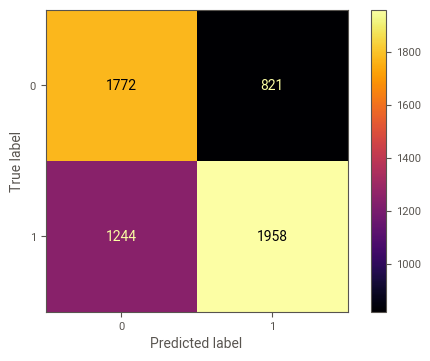

Градиентный бустинг.
Тестовая выборка.
Полнота 0.611
Точность 0.644


In [31]:
prediction_test_gb = gb.predict(X_test_ohe)

ConfusionMatrixDisplay.from_predictions(y_test, prediction_test_gb,
                                        cmap='inferno')
plt.show()

print('Градиентный бустинг.\n'
      'Тестовая выборка.')
print(f'Полнота {recall_score(y_test, prediction_test_gb):.3f}')
print(f'Точность {accuracy_score(y_test, prediction_test_gb):.3f}')


Судя по матрице ошибок, найденная модель правильно предсказывает больше половины виновных в аварии и довольно точно определяет тех, кто не является виновником дтп.

Проанализируем важность признаков.

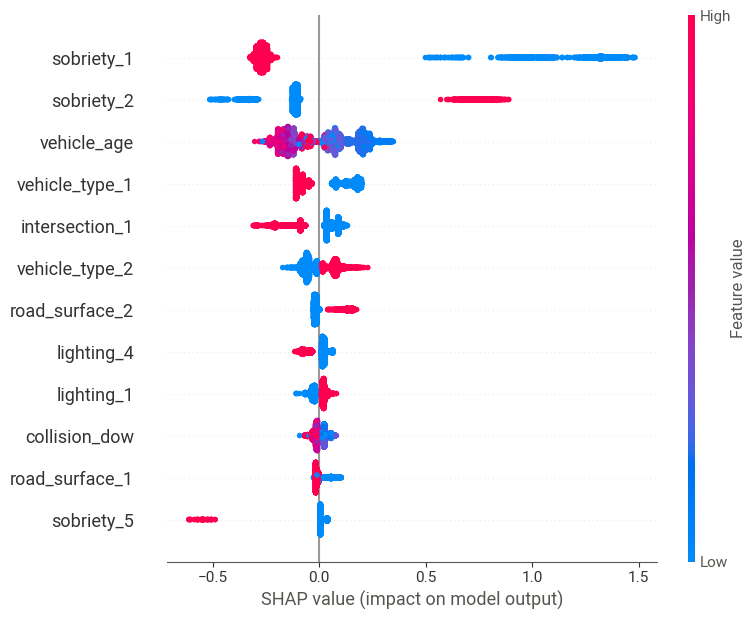

In [32]:
shap_gb = shap.TreeExplainer(gb).shap_values(X_test_ohe)
shap.summary_plot(shap_gb, X_test_ohe, plot_size='auto', max_display=12)


Из диаграммы важности признаков можно видеть, что вероятность виновности в аварии повышают:
- алкогольное опьянение
- наличие ручной коробки передач
- влажное или заснеженное состояние дорожного полотна
- дневное освещение
Эти факторы, по-видимому, ухудшают управляемость автомобилем.

Вероятность виновности в ДТП понижают:
- трезвое состояние водителя
- тип кузова автомобиля седан
- наличие перекрестка на пути следования автомобиля
- наличие искусственного освещения
- сухое состояние дороги
Данные факторы, наоборот, улучшают условия вождения и повышают управляемость автомобилем.

Диаграмма важности признаков показала, что возраст автомобиля влияет на вероятность виновности в аварии. Проведем графический анализ этого признака.

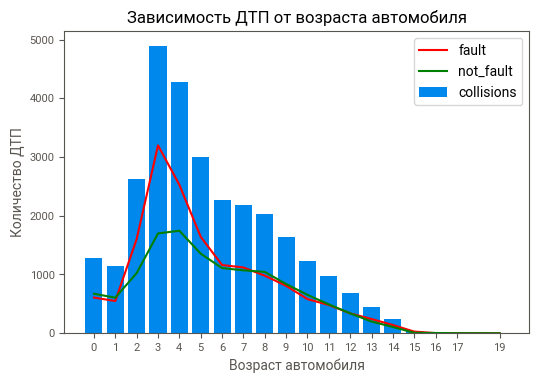

In [33]:
vehicle_age_df = df.groupby(by='vehicle_age')['fault']\
                   .agg(['count', 'sum'])\
                   .rename(columns={'count': 'collisions', 'sum': 'fault'})[:-1]
vehicle_age_df['not_fault'] = vehicle_age_df['collisions'] - vehicle_age_df['fault']

plt.bar(vehicle_age_df.index.tolist(),
        vehicle_age_df['collisions'].values.tolist(), label='collisions')
plt.plot(vehicle_age_df.index.tolist(),
        vehicle_age_df['fault'].values.tolist(), label='fault', color='red')
plt.plot(vehicle_age_df.index.tolist(),
        vehicle_age_df['not_fault'].values.tolist(), label='not_fault', color='green')
plt.xticks(vehicle_age_df.index.tolist())
plt.ylabel('Количество ДТП')
plt.xlabel('Возраст автомобиля')
plt.title('Зависимость ДТП от возраста автомобиля')
plt.legend()
plt.show()


Можно видеть, что вероятность виновности водителя повышается если он управляет автомобилем в возрасте от 2 до 5 лет и достигает максимума в возрасте 3 года. Вероятно, это связано с агрессивным стилем вождения данных автомобилей. В случае новых автомобилей (0 - 1 год) люди пытаются пользоваться ими аккуратно, а техническое состояние старых не позволяет их агрессивное использование. Также с увеличением возраста автомобиля повышается стаж вождения водителя, что снижает вероятность аварии. Найденная закономерность подсказывает нам, что в набор данных можно добавить информацию о водительском стаже клиента.

## Выводы

В работе найдена модель, которая позволяет с точностью 63 % определить вероятность виновности водителя в ДТП. Достигнут столь невысокий результат, т.к. в наборе данных довольно много информации о погодных условиях и состоянии дорог, но мало информации, описывающей непосредственно водителя.

- Для повышения точности предсказания необходимо добавить информацию, напрямую относящуюся к водителю. Например, длительность стажа вождения, аккуратность обращения с автомобилем и аккуратность вождения, соблюдение скоростного режима, история о прошлых случаях дтп с его участием, особенности состояния здоровья.
- Кроме этого можно тщательней отслеживать техническое состояние автомобиля и снижение его управляемости, для этого нужно проводить регулярные техосмотры и информацию о них также добавить в набор данных.
- Можно отслеживать сосредоточенность водителя при управлении автомобилем. Для этого возможно следить за перемещением глаз с помощью специального трекера (eye tracker), вмонтированного в приборную панель. Данную информацию добавлять в профиль водителя и использовать для предсказаний.
- Дополнительно, для исключения случаев вождения в нетрезвом виде можно оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место.